# Analysis On Stock and Gold Price with Time Series Data

## Importing libraries

In [56]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.vector_ar.vecm import select_order
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.vector_ar.var_model import VARResults

## Loading the dataset 

In [57]:
data = pd.read_csv('data.csv')

## Data extraction

In [58]:
org_gold = data['Gold Price']
gold_data = org_gold.replace([np.inf, -np.inf], np.nan).dropna()
org_stock = data['Stock Index']
stock_data = org_stock.replace([np.inf, -np.inf], np.nan).dropna()

## Check stationary with visual test and ADF test

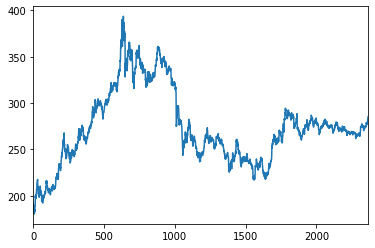

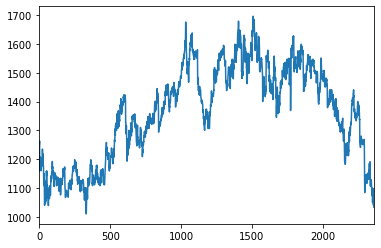

In [59]:
goldSeries = pd.Series(gold_data)
goldSeries.plot()
pyplot.show()

stockSeries = pd.Series(stock_data)
stockSeries.plot()
pyplot.show()

In [60]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adf_test(gold_data)
adf_test(stock_data)

Results of Dickey-Fuller Test:
Test Statistic                   -2.181148
p-value                           0.213158
#Lags Used                       20.000000
Number of Observations Used    2345.000000
Critical Value (1%)              -3.433142
Critical Value (5%)              -2.862773
Critical Value (10%)             -2.567427
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -1.890728
p-value                           0.336435
#Lags Used                        4.000000
Number of Observations Used    2361.000000
Critical Value (1%)              -3.433123
Critical Value (5%)              -2.862765
Critical Value (10%)             -2.567422
dtype: float64


Results show the test statistic > critical value and p-value > 5%, so the series is non-stationary.

## Data cleaning: transform into non-stationary time series

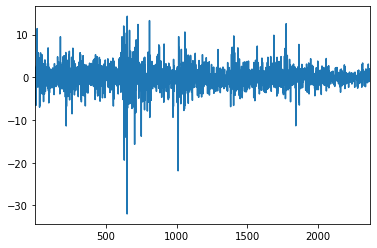

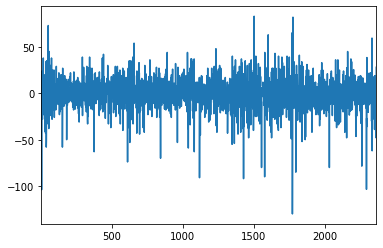

In [61]:
gold_diff0 = gold_data - gold_data.shift(1)
gold_diff0.dropna().plot()
pyplot.show()

stock_diff0 = stock_data - stock_data.shift(1)
stock_diff0.dropna().plot()
pyplot.show()

gold_diff = gold_diff0.replace([np.inf, -np.inf], np.nan).dropna()
stock_diff = stock_diff0.replace([np.inf, -np.inf], np.nan).dropna()

## Check stationary after first-diff

In [62]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adf_test(gold_diff)
adf_test(stock_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.061648e+01
p-value                        5.657739e-19
#Lags Used                     1.900000e+01
Number of Observations Used    2.345000e+03
Critical Value (1%)           -3.433142e+00
Critical Value (5%)           -2.862773e+00
Critical Value (10%)          -2.567427e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -27.438349
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    2361.000000
Critical Value (1%)              -3.433123
Critical Value (5%)              -2.862765
Critical Value (10%)             -2.567422
dtype: float64


## Data visualization

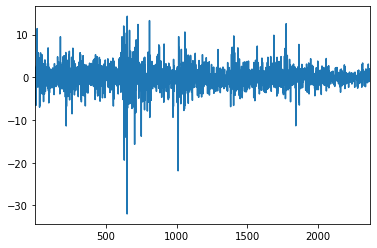

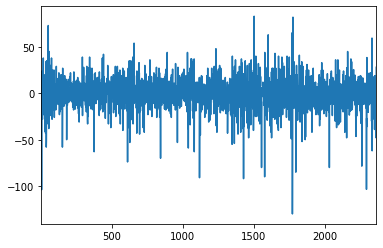

In [63]:
goldSeries = pd.Series(gold_diff)
goldSeries.plot()
pyplot.show()

stockSeries = pd.Series(stock_diff)
stockSeries.plot()
pyplot.show()

## Test for cointergration

In [64]:
result = sm.tsa.stattools.coint(gold_data, stock_data)
print(result)

(-2.1553562319247654, 0.4474903899530853, array([-3.90107682, -3.33871477, -3.04624381]))


p-value = 0.4474903899530853 < 5%, we can reject the null hypothesis that there is no cointegrating relationship

## VAR model

In [65]:
newdiff = {'goldPrice': gold_diff,'stockIndex': stock_diff}
newdiffSeries = pd.DataFrame(newdiff)
dataframe = newdiffSeries[['goldPrice','stockIndex']]

In [66]:
#choose lag
lag = select_order(dataframe, 12)
print(lag)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 3, BIC -> 0, FPE -> 3, HQIC -> 0>


/Users/jingjing/Documents/Important/University/CUMA/2018winter/5029/paper/code/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jingjing/Documents/Important/University/CUMA/2018winter/5029/paper/code/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jingjing/Documents/Important/University/CUMA/2018winter/5029/paper/code/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jingjing/Documents/Important/University/CUMA/2018winter/5029/paper/code/venv/lib/python3.7/site-packages/statsmode

In [67]:
mod = sm.tsa.VAR(dataframe)

/Users/jingjing/Documents/Important/University/CUMA/2018winter/5029/paper/code/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## Fitting model

In [68]:
fitMod = mod.fit(2)
print(fitMod.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 17, Sep, 2019
Time:                     18:34:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.68167
Nobs:                     2363.00    HQIC:                   7.66615
Log likelihood:          -15743.0    FPE:                    2115.96
AIC:                      7.65727    Det(Omega_mle):         2107.04
--------------------------------------------------------------------
Results for equation goldPrice
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.041177         0.055627            0.740           0.459
L1.goldPrice         -0.028815         0.020599           -1.399           0.162
L1.stockIndex         0.001710         0.003255         

## Granger Causality test

In [69]:
granger_result = grangercausalitytests(dataframe, maxlag=2)
print(granger_result)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2838  , p=0.5943  , df_denom=2361, df_num=1
ssr based chi2 test:   chi2=0.2841  , p=0.5940  , df=1
likelihood ratio test: chi2=0.2841  , p=0.5940  , df=1
parameter F test:         F=0.2838  , p=0.5943  , df_denom=2361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1836  , p=0.8323  , df_denom=2358, df_num=2
ssr based chi2 test:   chi2=0.3679  , p=0.8320  , df=2
likelihood ratio test: chi2=0.3679  , p=0.8320  , df=2
parameter F test:         F=0.1836  , p=0.8323  , df_denom=2358, df_num=2
{1: ({'ssr_ftest': (0.2837628118868503, 0.5942956060715208, 2361.0, 1), 'ssr_chi2test': (0.2841233745449022, 0.5940112592990259, 1), 'lrtest': (0.28410630186772323, 0.5940223451741761, 1), 'params_ftest': (0.28376281188883923, 0.5942956060703282, 2361.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x12654d750>, <statsmodels.regression.linear_model.Regres

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1.